# Pymaceuticals Inc.
---

### Analysis

- Our data includes 1892 timepoints for 248 mice. Mice were given either a Placebo or 1 of 9 treatment options: Capomulin, Ceftamin, Infubinol, Ketapril, Naftisol, Propriva, Ramicane, Stelasyn, and Zoniferol. The sex of the mice was evenly split with 50.4% male and 49.6% female.
- The four primary treatments of interest were Capomulin, Ramicane, Infubinol, and Ceftamin. Ramicane and Capomulin appear to be more effective than Infubinol and Ceftamin. 
- The individual line plot of a single subject demonstrates that in this case the tumor size continued to increase momentarily until the mouse has taken the medication until about timepoint 20. Then, the size of the tumor began to reduce with a few variations in growth.
- The overall weight of the mice was positively related to the size of the tumor, with heavier mice having larger tumors and vice versa. This information can be used to argue that the overall weight of the mice should be a covariate in future analyses examining the tumor volume. Doing so would help control for variations in the tumor size that are due to the size/weight of the mice.

 

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import seaborn as sns

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single DataFrame
# According to AskBCS, this should be a left join, but right join provided me the table that was closest to the example
mouse_data = pd.merge(mouse_metadata, study_results, on="Mouse ID", how="right")

# Display the data table for preview
mouse_data

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,Capomulin,Female,9,22,0,45.000000,0
1,f932,Ketapril,Male,15,29,0,45.000000,0
2,g107,Ketapril,Female,2,29,0,45.000000,0
3,a457,Ketapril,Female,11,30,0,45.000000,0
4,c819,Ketapril,Male,21,25,0,45.000000,0
...,...,...,...,...,...,...,...,...
1888,r944,Capomulin,Male,12,25,45,41.581521,2
1889,u364,Capomulin,Male,18,17,45,31.023923,3
1890,p438,Ceftamin,Female,11,26,45,61.433892,1
1891,x773,Placebo,Female,21,30,45,58.634971,4


In [3]:
# Checking the number of mice.
number_of_mice = mouse_data["Mouse ID"].nunique()
number_of_mice

249

In [4]:
# Our data should be uniquely identified by Mouse ID and Timepoint
# Get the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
duplicate_mice = mouse_data[mouse_data.duplicated(["Mouse ID", "Timepoint"])]
duplicate_mice_unique = duplicate_mice["Mouse ID"].unique()
duplicate_mice_unique

array(['g989'], dtype=object)

In [5]:
# Optional: Get all the data for the duplicate mouse ID. 
duplicate_mouse_data = mouse_data[mouse_data["Mouse ID"] == "g989"]
duplicate_mouse_data

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
107,g989,Propriva,Female,21,26,0,45.000000,0
137,g989,Propriva,Female,21,26,0,45.000000,0
329,g989,Propriva,Female,21,26,5,48.786801,0
360,g989,Propriva,Female,21,26,5,47.570392,0
620,g989,Propriva,Female,21,26,10,51.745156,0
681,g989,Propriva,Female,21,26,10,49.880528,0
815,g989,Propriva,Female,21,26,15,51.325852,1
869,g989,Propriva,Female,21,26,15,53.442020,0
950,g989,Propriva,Female,21,26,20,55.326122,1
1111,g989,Propriva,Female,21,26,20,54.657650,1


In [6]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.

# Note: This step appears to be removing the duplicate mouse entirely from the dataset
# Rather than just removing the duplicate rows
clean_mouse_data = mouse_data[mouse_data["Mouse ID"] != "g989"]
clean_mouse_data


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,Capomulin,Female,9,22,0,45.000000,0
1,f932,Ketapril,Male,15,29,0,45.000000,0
2,g107,Ketapril,Female,2,29,0,45.000000,0
3,a457,Ketapril,Female,11,30,0,45.000000,0
4,c819,Ketapril,Male,21,25,0,45.000000,0
...,...,...,...,...,...,...,...,...
1888,r944,Capomulin,Male,12,25,45,41.581521,2
1889,u364,Capomulin,Male,18,17,45,31.023923,3
1890,p438,Ceftamin,Female,11,26,45,61.433892,1
1891,x773,Placebo,Female,21,30,45,58.634971,4


In [7]:
# Checking the number of mice in the clean DataFrame.
clean_number_of_mice = clean_mouse_data["Mouse ID"].nunique()
clean_number_of_mice

248

## Summary Statistics

In [8]:
# Generate a summary statistics table of mean, median, variance, 
# standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
grouped_by_drug = clean_mouse_data.groupby("Drug Regimen")

# mean, median, variance, standard deviation, and SEM of the tumor volume. 
mean_tumor_volume = grouped_by_drug["Tumor Volume (mm3)"].mean()
median_tumor_volume = grouped_by_drug["Tumor Volume (mm3)"].median()
variance_tumor_volume = grouped_by_drug["Tumor Volume (mm3)"].var()
std_tumor_volume = grouped_by_drug["Tumor Volume (mm3)"].std()
sem_tumor_volume = grouped_by_drug["Tumor Volume (mm3)"].sem()

# Assemble the resulting series into a single summary DataFrame.
summary_stats = pd.DataFrame({"Mean Tumor Volume": mean_tumor_volume,
                                "Median Tumor Volume": median_tumor_volume,
                                "Tumor Volume Variance": variance_tumor_volume,
                                "Tumor Volume SD": std_tumor_volume,
                                "Tumor Volume SEM": sem_tumor_volume})
summary_stats


,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume SD,Tumor Volume SEM
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [9]:
# A more advanced method to generate a summary statistics table of mean, median, variance, standard deviation,
# and SEM of the tumor volume for each regimen (only one method is required in the solution)

# Using the aggregation method, produce the same summary statistics in a single line


# I have already completed this step above

## Bar and Pie Charts

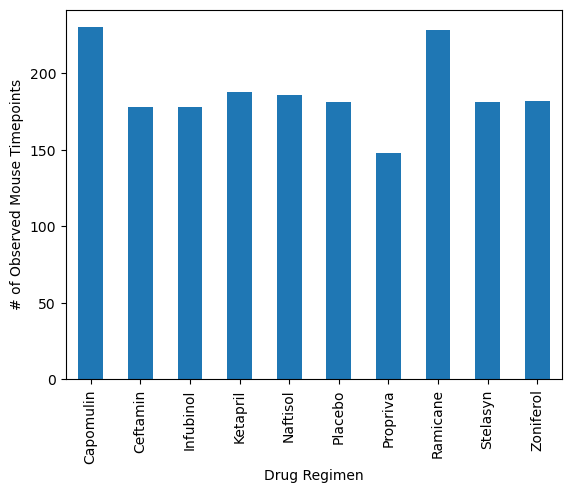

In [10]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using Pandas.

# We already have the data grouped by drug, so we need to find out the number of rows in each group
count_by_drug = grouped_by_drug["Mouse ID"].count()
count_chart = count_by_drug.plot(kind="bar", ylabel="# of Observed Mouse Timepoints", xlabel="Drug Regimen")


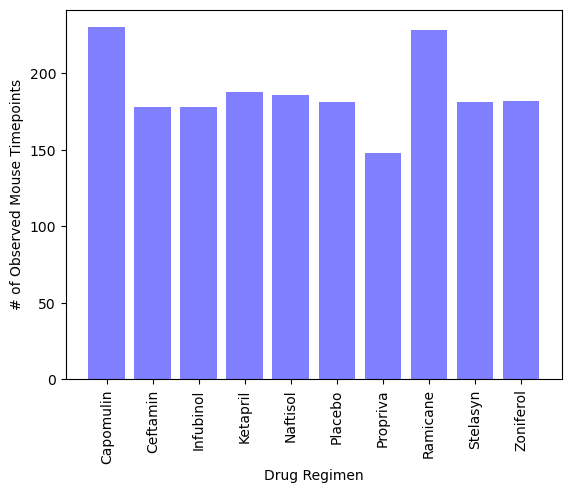

In [11]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using pyplot.

# Create values for the x axis
x_axis_drug = np.arange(len(count_by_drug))

# Create values for the y axis
y_axis_drug = count_by_drug.values

# Create a list of the drug names
drug_names = count_by_drug.index

# Create the ticks for our bar chart's x axis
tick_locations_drug = [value for value in x_axis_drug]

# Create the bar chart
plt.bar(x_axis_drug, y_axis_drug, color="b", alpha=0.5, align="center")

# Add the ticks to the x axis
plt.xticks(tick_locations_drug, drug_names, rotation="vertical")

# Create labels for the x and y axes
plt.xlabel("Drug Regimen")
plt.ylabel("# of Observed Mouse Timepoints")

# Show the chart
plt.show()

<Axes: ylabel='Sex'>

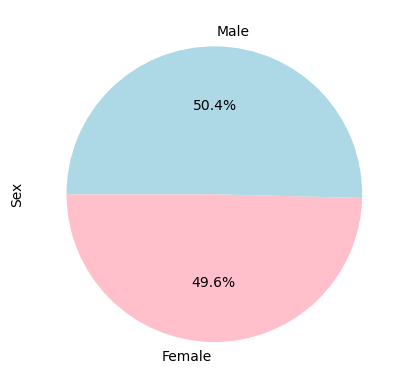

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas

# Sex will not change across timepoints, so we need to know the sex of each unique ID
# Capture sex at timepoint 0 (the first timepoint)
first_timepoint = clean_mouse_data[clean_mouse_data["Timepoint"] == 0].copy()

# Only get our variables of interest
first_timepoint = first_timepoint[['Sex']]
# first_timepoint

# Create a dataframe with the information we need
# sex_of_mice_df = ((first_timepoint['Sex'].value_counts() / first_timepoint['Sex'].count()) * 100).map('{:.1f}%'.format)
# sex_of_mice_df

# Note 1: This does not include the duplicate mouse that we threw out earlier in the code because 
# this pie chart should represent the statistics that we pulled
# The excluded mouse is no longer part of the results and therefore is not included in descriptive charts

# Note 2: In our dataset, our subjects (the mice) are showing up multiple times because each timepoint is a row in the data
# Our goal is to find out the sex of the mice used in the study
# Including all the timepoints would artificially inflate the number of mice in the study

# Colors for our pie chart
colors = ["pink", "lightblue"]

# Create the pie chart
# This method puts the code in a line, rather than making another dataframe
first_timepoint.groupby(['Sex']).value_counts().plot(kind='pie', ylabel='Sex', startangle=180, autopct='%1.1f%%', legend=False, colors=colors)

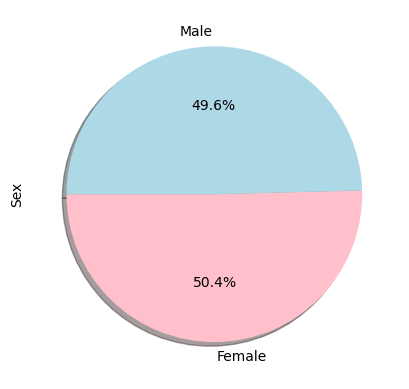

In [13]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

# Create the lists
labels_sex = first_timepoint['Sex'].unique()
sizes_sex = first_timepoint['Sex'].value_counts()
# print(labels_sex)
# print(sizes_sex)

# The colors of each section of the pie chart
colors = ["pink", "lightblue"]

# Create the pie chart based upon the values above
plt.pie(sizes_sex, labels=labels_sex, colors=colors, autopct='%1.1f%%', shadow=True, startangle=180)
plt.ylabel("Sex")
plt.show()


## Quartiles, Outliers and Boxplots

In [14]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse

# What is the final timepoint for each mouse?
# This is assuming that all mice have the same number of timepoints
# If they do not, then we need to find the max timepoint for each mouse
# We can do this by grouping by mouse ID and then finding the max timepoint
grouped_by_mouse = clean_mouse_data.groupby("Mouse ID")
max_timepoint = grouped_by_mouse["Timepoint"].max()
# max_timepoint

# max_timepoint revealed that we do not have the same number of timepoints for each mouse
# We need to find the max timepoint for each mouse
# We will merge max_timepoint with the original dataframe to get the tumor volume at the last timepoint
last_timepoint = clean_mouse_data.loc[clean_mouse_data.groupby("Mouse ID")["Timepoint"].idxmax(), ["Mouse ID","Timepoint","Tumor Volume (mm3)", "Drug Regimen", "Weight (g)"]]
# last_timepoint

# Filter by the drugs of interest
# We can use the isin() method to filter by multiple values
drug_interest = last_timepoint[last_timepoint["Drug Regimen"].isin(["Capomulin", "Ramicane", "Infubinol", "Ceftamin"])]
drug_interest



,Mouse ID,Timepoint,Tumor Volume (mm3),Drug Regimen,Weight (g)
1804,a203,45,67.973419,Infubinol,23
1786,a251,45,65.525743,Infubinol,25
1856,a275,45,62.999356,Ceftamin,28
1773,a411,45,38.407618,Ramicane,22
1836,a444,45,43.047543,Ramicane,25
...,...,...,...,...,...
1767,y769,45,68.594745,Ceftamin,27
1797,y793,45,31.896238,Capomulin,17
1766,y865,45,64.729837,Ceftamin,26
1799,z578,45,30.638696,Ramicane,16


Text(0.5, 1.0, 'Final Tumor Volume by Drug Regimen')

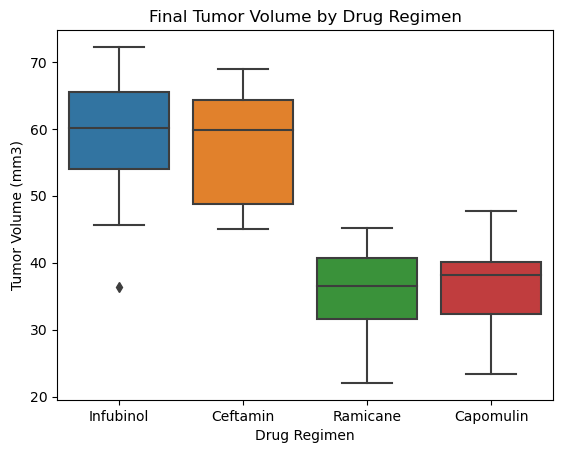

In [15]:
# Generate a box plot that shows the distrubution of the tumor volume for each treatment group.

# I decided to use the seaborn's boxplot method because it was easier to understand and made the boxplot in one line of code
myplot = sns.boxplot(x="Drug Regimen", y="Tumor Volume (mm3)", data=drug_interest)
myplot.set_title("Final Tumor Volume by Drug Regimen")

In [16]:
# Generate a box plot that shows the distrubution of the tumor volume for each treatment group.


## Line and Scatter Plots

Text(0.5, 1.0, 'Capomulin treatment of l509')

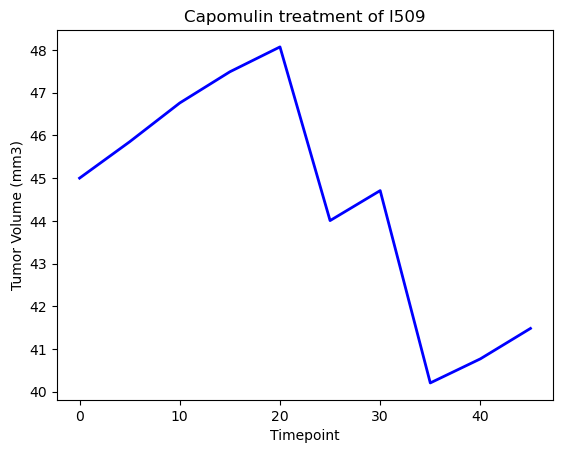

In [17]:
# Generate a line plot of tumor volume vs. time point for a single mouse treated with Capomulin

# Create a dataframe with only Capomulin data
capomulin_data1 = clean_mouse_data.loc[clean_mouse_data["Drug Regimen"] == "Capomulin"].copy()

# Print the "Mouse ID" column to see the unique values
mice_on_capomulin = capomulin_data1["Mouse ID"].unique()
# print(mice_on_capomulin)

# Select a mouse ID
mouse_id = "l509"

# Create a dataframe with only the selected mouse ID
mouse_of_interest = capomulin_data1.loc[capomulin_data1["Mouse ID"] == mouse_id].copy()

# Plot a line plot of tumor volume vs. time point for a single mouse treated with Capomulin
plt.plot(mouse_of_interest["Timepoint"], mouse_of_interest["Tumor Volume (mm3)"], color="blue", linewidth=2)
plt.xlabel("Timepoint")
plt.ylabel("Tumor Volume (mm3)")
plt.title("Capomulin treatment of " + mouse_id)


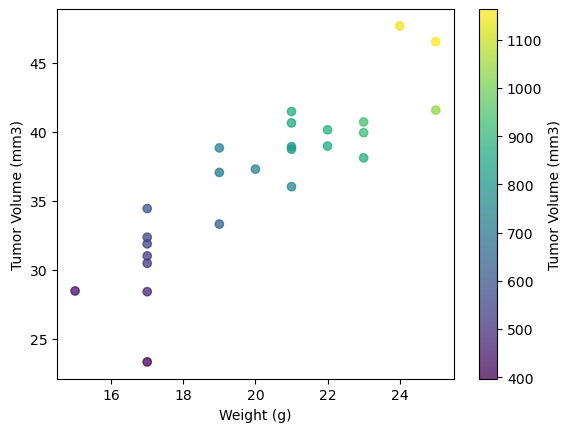

In [18]:
# Generate a scatter plot of mouse weight vs. the average observed tumor volume for the entire Capomulin regimen
capomulin_data2 = last_timepoint.loc[last_timepoint["Drug Regimen"] == "Capomulin"].copy()

# Create new columns that will multiply tumor volume and weight
capomulin_data2["Color Value"] = capomulin_data2["Tumor Volume (mm3)"] * capomulin_data2["Weight (g)"]

plt.scatter(capomulin_data2["Weight (g)"], capomulin_data2["Tumor Volume (mm3)"], marker="o", alpha=0.75, c=capomulin_data2["Color Value"])
clb = plt.colorbar()
clb.set_label("Tumor Volume (mm3)")
plt.xlabel("Weight (g)")
plt.ylabel("Tumor Volume (mm3)")
plt.show()

## Correlation and Regression

The correlation between mouse weight and the average tumor volume is 0.88.


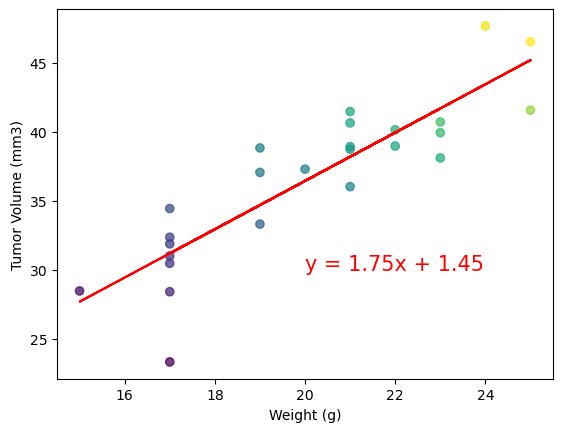

In [28]:
# Calculate the correlation coefficient and a linear regression model 
# for mouse weight and average observed tumor volume for the entire Capomulin regimen

# We want to use the 2nd dataset that we created
# Because it is using the last timepoint

# We are going to assume that the data meets the assumptions of linear regression (normallity, independence, linearity, continuous, and equal variance)
correlation = st.pearsonr(capomulin_data2["Weight (g)"], capomulin_data2["Tumor Volume (mm3)"])
print(f"The correlation between mouse weight and the average tumor volume is {round(correlation[0],2)}.")

#Calculate the linear regression model
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(capomulin_data2["Weight (g)"], capomulin_data2["Tumor Volume (mm3)"])
regress_values = capomulin_data2["Weight (g)"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(capomulin_data2["Weight (g)"], capomulin_data2["Tumor Volume (mm3)"], marker="o", alpha=0.75, c=capomulin_data2["Color Value"])
plt.plot(capomulin_data2["Weight (g)"],regress_values,"r-")
plt.annotate(line_eq,xy=(20,30),fontsize=15,color="red")
plt.xlabel("Weight (g)")
plt.ylabel("Tumor Volume (mm3)")
plt.show()


# Create a scatterplot with a linear regression line using seaborn
# sns.regplot(x="Weight (g)", y="Tumor Volume (mm3)", data=capomulin_data2)
